<a href="https://colab.research.google.com/github/rafaelturon/pocs/blob/master/ml_modelo_regressao_carros_usados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning
###Exemplo de modelo de regressão p/ previsão de preços de venda de carros usados
* Este tutorial foi inspirado no repositório [Machine Learning](https://github.com/lfbraz/azure-databricks/blob/master/notebooks/ml-modelo-regressao-carros-usados.ipynb).

### Neste tutorial faremos uma [regressão linear simples](https://pt.wikipedia.org/wiki/Regress%C3%A3o_linear_simples) em que o objetivo será prever o PREÇO (y) de venda de um determinado modelo de veículo se baseando em algumas variáveis de entrada (X) 

A base de dados utilizada pode ser obtida no [link](https://github.com/lfbraz/machine-learning-tutorial/blob/master/datasets/dataset-carros-usados.csv) e foi baseada na versão [original](https://databricksdemostore.blob.core.windows.net/data/02.02/UsedCars.csv) disponibilizada pela Databricks, em que foi adaptada e traduzida para Português-Brasil.

##Importar base de dados
Utilizarei o [Google Colab](https://colab.research.google.com/) para treino do modelo, porém este tutorial pode ser utilizado com qualquer plataforma (sendo necessário apenas que o método de importação seja adaptado).

# **Running Pyspark in Colab**

Spark is a unified analytics engine for large-scale data processing. It provides high-level APIs in Scala, Java, Python, and R, and an optimized engine that supports general computation graphs for data analysis. It also supports a rich set of higher-level tools including Spark SQL for SQL and DataFrames, MLlib for machine learning, GraphX for graph processing, and Structured Streaming for stream processing.

https://spark.apache.org/

In [9]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 64kB/s 
     |████████████████████████████████| 204kB 37.7MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=1e3c44bd48ecaebaa7b9b2887e2b1c954e386fd4017ad941977c033095845a09
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


##Ler o arquivo .csv em um Spark DataFrame

Utilizaremos as segmentos opções: <br/>
<br/>
* format: CSV
* inferSchema: true / Permite que os tipos de dados sejam automaticamente inferidos
* header: true / Primeira linha será entendida como o cabeçalho
* sep: ";" / Será utilizado como delimitador de colunas o carácter ";"
* load: path / O caminho do arquivo que será carregado

In [ ]:
import pyspark
from pyspark import SparkFiles

filename = "dataset-carros-usados.csv"
url = "https://raw.githubusercontent.com/lfbraz/machine-learning-tutorial/master/datasets/{}".format(filename)

spark = SparkSession.builder.appName('pandasToSparkDF').getOrCreate()
spark.sparkContext.addFile(url)

file_type = "csv"
infer_schema = "true"
first_row_is_header = "true"
delimiter = ";"

carros_usados = spark.read.format(file_type) \
                     .option("inferSchema", infer_schema) \
                     .option("header", first_row_is_header) \
                     .option("sep", delimiter) \
                     .load("file://"+SparkFiles.get(filename))

## Visualização dos Dados

A tabela de carros usados possui os seguintes campos:<br/>
<br/>
* **PRECO**: Preço de venda do veículo (variável target / previsão)
* **IDADE_ANOS**: Número de anos desde a data de fabricação do veículo
* **KM**: Número de kilometros rodados pelo veículo
* **TIPO_COMBUSTIVEL**: Tipo de combustível utilizado
* **[HP](https://en.wikipedia.org/wiki/Horsepower)**: Medida de potência do veículo
* **COR_METALICA**: Indica se o veículo possui cor metálica (1 para sim e 0 para não). Pode indicar maior valorização
* **AUTOMATICO**: Indica se o veículo é automático (1 para sim e 0 para não)
* **[CC](https://pt.wikipedia.org/wiki/Cilindrada)**: Cilindradas do veículo
* **QTD_PORTAS**: Número de portas do veículo
* **PESO_KG**: Peso em quilograma do veículo

Com o comando `display(carros_usados)` podemos analisar o DataFrame

In [24]:
carros_usados.show(n=5)

+-------+----------+--------+----------------+---+------------+----------+----+----------+-------+
|  PRECO|IDADE_ANOS|      KM|TIPO_COMBUSTIVEL| HP|COR_METALICA|AUTOMATICO|  CC|QTD_PORTAS|PESO_KG|
+-------+----------+--------+----------------+---+------------+----------+----+----------+-------+
| 7450.0|      65.0| 82000.0|        GASOLINA| 86|           1|         0|1300|         3|   1015|
| 7250.0|      74.0|130025.0|        GASOLINA|110|           1|         0|1600|         3|   1050|
| 8950.0|      80.0| 64000.0|        GASOLINA|110|           0|         0|1600|         3|   1055|
|11450.0|      54.0| 62987.0|        GASOLINA|110|           0|         0|1600|         5|   1080|
|   null|      42.0| 38932.0|        GASOLINA|110|           1|         0|1600|         3|   1040|
+-------+----------+--------+----------------+---+------------+----------+----+----------+-------+
only showing top 5 rows



Executamos o Display do DataFrame podemos na própria célula indicar os tipos de gráficos que queremos visualizar (clicando no icone gráfico abaixo do DataFrame e em `PlotOptions`).

Abaixo é possível com o comando `Display` exibir uma visualização por Tipo de Combustível e Preço (utilizando 30 `bins` [número de colunas] ) alterando-se o `Plot Options` (somente disponível para Azure Databricks).

In [25]:
display(carros_usados)

DataFrame[PRECO: double, IDADE_ANOS: double, KM: double, TIPO_COMBUSTIVEL: string, HP: int, COR_METALICA: int, AUTOMATICO: int, CC: int, QTD_PORTAS: int, PESO_KG: int]

Também podemos utilizar outras bibliotecas para análise gráfica como o `matplotlib` ou `seaborn`. Neste caso pode-se converter o DataFrame Spark para um DataFrame Pandas (com isso a performance pode ser degradada).

Abaixo um [histograma](https://pt.wikipedia.org/wiki/Histograma) gerado a partir do preço de venda do veículo utilizando o matplotlib a partir de um [DataFrame do Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

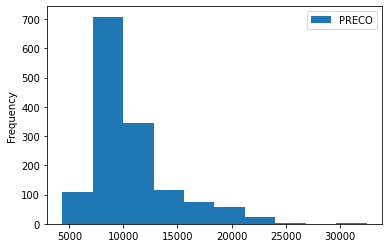

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline 

display(carros_usados.toPandas().plot(kind='hist', y='PRECO'))

# Criando uma regressão linear simples

Podemos iniciar investigando se a idade do veículo pode influenciar seu preço de venda.

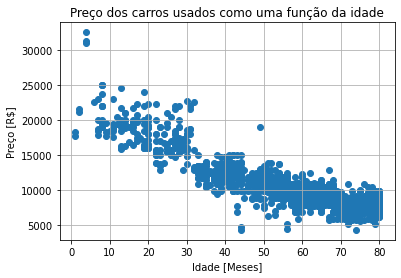

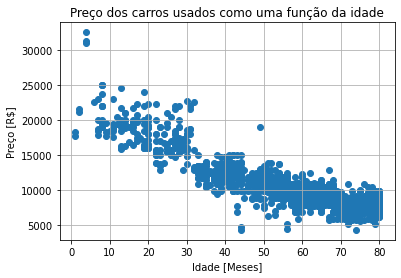

In [27]:
carros_usados_pd = carros_usados.toPandas()

fig, ax = plt.subplots()

# Populate the figure
plt.scatter(carros_usados_pd['IDADE_ANOS'], carros_usados_pd['PRECO'])

# Set various labels
plt.title('Preço dos carros usados como uma função da idade')
plt.ylabel('Preço [R$]')
plt.xlabel('Idade [Meses]')

# Extras?
plt.grid() # Turn plot-grid on

# Show figure
display(fig)

Repare que quanto maior a idade do veículo menor o seu preço de venda (make sense??).

Geralmente quando falamos em Machine Learning (aprendizado de máquina) estamos pensando em uma tarefa específica. No nosso caso, a tarefa básica 
é a de **prever o preço de venda de um veículo** utilizando para isso dados históricos de vendas de outros veículos.

Regressão Linear é uma das primeiras técnicas estatísticas aprendidas para previsão de dados que se comportam de forma linear 🙄. <br/><br/>
E o que isso significa ? Basicamente estamos falando que quando uma variável cresce (ou diminui) outra variável também têm o mesmo comportamento, como por exemplo, o **PREÇO** do veículo com a sua **IDADE** em meses (que acabamos de analisar de forma gráfica).

Este comportamento, para os mais entendidos, é feito através da famosa equação \\(y = ax + b\\).

No exemplo dado estamos falando apenas na relação de duas variáveis (PREÇO e IDADE), porém a ideia é utilizar diferentes variáveis no mesmo modelo linear.

Neste tipo de situação (que é a mais comum) a visualização é mais complexa pois a previsão não se dará por uma única reta (mas sim por hiperplanos 😳). Quem quiser entender mais sobre isso, recomendo o vídeo [Regressão Linear Múltipla](https://drive.google.com/file/d/1MKIO-oe8mtz92rlZp3eZJIYVmQSpW0Pi/view) de uma aula dada no IME/USP sobre o assunto.

## Tratamento dos dados
Antes de aplicarmos um modelo de Regressão Linear precisamos primeiramente tratar os dados que serão ENTRADA do modelo, isto é, precisaremos limpar, padronizar e enriquecer os dados que serão utilizados para treinamento do modelo.

In [28]:
carros_usados.show(n=5)

+-------+----------+--------+----------------+---+------------+----------+----+----------+-------+
|  PRECO|IDADE_ANOS|      KM|TIPO_COMBUSTIVEL| HP|COR_METALICA|AUTOMATICO|  CC|QTD_PORTAS|PESO_KG|
+-------+----------+--------+----------------+---+------------+----------+----+----------+-------+
| 7450.0|      65.0| 82000.0|        GASOLINA| 86|           1|         0|1300|         3|   1015|
| 7250.0|      74.0|130025.0|        GASOLINA|110|           1|         0|1600|         3|   1050|
| 8950.0|      80.0| 64000.0|        GASOLINA|110|           0|         0|1600|         3|   1055|
|11450.0|      54.0| 62987.0|        GASOLINA|110|           0|         0|1600|         5|   1080|
|   null|      42.0| 38932.0|        GASOLINA|110|           1|         0|1600|         3|   1040|
+-------+----------+--------+----------------+---+------------+----------+----+----------+-------+
only showing top 5 rows



O primeiro ponto importante é analisarmos se existem valores faltantes para cada uma das colunas que serão utilizadas no modelo. 

Repare que existem valores `null` (faltantes) no conjunto de dados analisado. Podemos checar estes valores através do comando abaixo:

In [29]:
from pyspark.sql.functions import isnan, when, col

for c in carros_usados.columns:
  carros_usados.where(col(c).isNull()).show()

+-----+----------+--------+----------------+---+------------+----------+----+----------+-------+
|PRECO|IDADE_ANOS|      KM|TIPO_COMBUSTIVEL| HP|COR_METALICA|AUTOMATICO|  CC|QTD_PORTAS|PESO_KG|
+-----+----------+--------+----------------+---+------------+----------+----+----------+-------+
| null|      42.0| 38932.0|        GASOLINA|110|           1|         0|1600|         3|   1040|
| null|      60.0|    null|        GASOLINA|110|           1|         0|1600|         5|   1070|
| null|      64.0|    null|          DIESEL| 72|           1|         0|2000|         5|   1135|
| null|      null| 71000.0|        GASOLINA|110|           0|         0|1600|         5|   1070|
| null|      null| 60239.0|        GASOLINA|110|           1|         0|1600|         5|   1075|
| null|      null|    null|        GASOLINA| 86|           1|         0|1300|         3|   1015|
| null|      72.0|105856.0|        GASOLINA| 86|           0|         0|1300|         3|   1015|
+-----+----------+--------+---

Existem diversas técnicas de tratamento de valores faltantes (substituição pela média, moda, etc). Para simplificarmos, o processo vamos simplesmente remover toda a linha em que seja encontrado algum valor faltante.

In [30]:
carros_usados = carros_usados.na.drop()

Outro ponto importante é analisarmos o *TIPO* das variáveis de entrada. Repare que a variável **TIPO_COMBUSTIVEL** é uma variável categórica em formato TEXTO e quando falamos em modelos de aprendizado de máquina precisamos que todas as variáveis de *INPUT* sejam de alguma forma retratadas de forma numérica. Desta forma, o modelo (que nada mais é do que uma expressão matemática, muitas vezes extremamente complexa) conseguirá utilizar os dados de forma apropriada.

Para tratamento da variável utilizaremos as técnicas `StringIndexer` e `OneHotEncoder` que permitem representar as varíaveis categóricas em um formato vetorial binário. 

Com a `StringIndexer` representaremos as varíaveis categóricas de forma numérica (ex: GASOLINA=0, DIESEL=1, etc).

In [32]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='TIPO_COMBUSTIVEL', outputCol='TIPO_COMBUSTIVEL_index')
indexed = indexer.fit(carros_usados).transform(carros_usados)
indexed.show()

+-------+----------+--------+--------------------+---+------------+----------+----+----------+-------+----------------------+
|  PRECO|IDADE_ANOS|      KM|    TIPO_COMBUSTIVEL| HP|COR_METALICA|AUTOMATICO|  CC|QTD_PORTAS|PESO_KG|TIPO_COMBUSTIVEL_index|
+-------+----------+--------+--------------------+---+------------+----------+----+----------+-------+----------------------+
| 7450.0|      65.0| 82000.0|            GASOLINA| 86|           1|         0|1300|         3|   1015|                   0.0|
| 7250.0|      74.0|130025.0|            GASOLINA|110|           1|         0|1600|         3|   1050|                   0.0|
| 8950.0|      80.0| 64000.0|            GASOLINA|110|           0|         0|1600|         3|   1055|                   0.0|
|11450.0|      54.0| 62987.0|            GASOLINA|110|           0|         0|1600|         5|   1080|                   0.0|
| 6950.0|      80.0| 62581.0|            GASOLINA|110|           0|         0|1600|         5|   1075|                

Repare que foi adicionada uma nova coluna chamada **TIPO_COMBUSTIVEL_index** com a representação numérica mencionada.

Também vamos utilizar a técnica de `OneHotEncoder` para transformação vetorial binária da variável que foi indexada (uma lista mais completa das técnicas pode ser encontrada no [link](https://spark.apache.org/docs/latest/ml-features.html) ). Para otimização deste processo ainda não vamos executar as transformações, vamos criar `Stages` (estágios de processamento das transformações) que serão posteriormente colocadas em um `Pipeline`).

In [34]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCols=["TIPO_COMBUSTIVEL_index"],
                                 outputCols=["TIPO_COMBUSTIVEL_vetor"])

stages = [indexer, encoder]

A variável `stages` contém os estágios de `StringIndexer` e `OneHotEncoder`, além deles utilizaremos também a técnica de `VectorAssembler` para consolidar todas as variáveis (features) que serão utilizadas para treinamento do modelo e adicionaremos mais este estágio na variável `stages`.

In [35]:
from pyspark.ml.feature import VectorAssembler
colunas_treino = ['IDADE_ANOS', 'KM', 'HP', 'COR_METALICA', 'AUTOMATICO', 'CC', 'QTD_PORTAS', 'PESO_KG', 'TIPO_COMBUSTIVEL_vetor']

assembler = VectorAssembler(inputCols=colunas_treino, outputCol="features")
stages += [assembler]

Com os estágios de tratamento já definidos devemos agora dividir o conjunto de dados entre dados de treino (utilizado para treinar o modelo) e testes (utilizado para avaliar a performance do modelo). Utilizaremos a proporção de 80% para treino e 20% para teste.

In [36]:
treino, teste = carros_usados.randomSplit([0.8, 0.2])

Com isso, finalmente 😆 podemos então realizar o treinamento de um modelo de Regressão Linear Simples.

Para isso vamos adicioná-lo no [`Pipeline`](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=onehotencoder#pyspark.ml.Pipeline) em conjunto com os outros estágios de tratamento de dados.

In [37]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

lr = LinearRegression(featuresCol = 'features', labelCol='PRECO')
stages += [lr]
 
partialPipeline = Pipeline().setStages(stages)
model = partialPipeline.fit(treino)

##Persistir o modelo

Para ser possível a reutilização do modelo treinado podemos persisti-lo para que possa ser carregado posteriormente (sem a necessidade de re-treinamento).

Mount Google Drive to save sample levels as they are generated.

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [47]:
# Persist model
model_save_name = 'carros_usados_model'
path = F"/content/gdrive/My Drive/{model_save_name}" 
model.save(path)

In [52]:
# Load model
from pyspark.ml import PipelineModel
model = PipelineModel.load(path)

Agora podemos também utilizar o modelo para fazer as predições na base de teste

## Predições na base TESTE

In [53]:
predicoes = model.transform(teste)

predicoes.show(n=5)

+------+----------+--------+----------------+---+------------+----------+----+----------+-------+----------------------+----------------------+--------------------+------------------+
| PRECO|IDADE_ANOS|      KM|TIPO_COMBUSTIVEL| HP|COR_METALICA|AUTOMATICO|  CC|QTD_PORTAS|PESO_KG|TIPO_COMBUSTIVEL_index|TIPO_COMBUSTIVEL_vetor|            features|        prediction|
+------+----------+--------+----------------+---+------------+----------+----+----------+-------+----------------------+----------------------+--------------------+------------------+
|5150.0|      56.0|113997.0|          DIESEL| 72|           1|         0|2000|         5|   1135|                   1.0|         (3,[1],[1.0])|[56.0,113997.0,72...| 9586.500678356479|
|5750.0|      76.0|183277.0|          DIESEL| 72|           0|         0|2000|         3|   1115|                   1.0|         (3,[1],[1.0])|[76.0,183277.0,72...| 5595.209481516402|
|5950.0|      72.0|105856.0|        GASOLINA| 86|           0|         0|1300|  

## Podemos também analisar os resultados das predições

Com o modelo treinado e as predições realizadas, vamos analisar a métrica de Erro quadrático médio [RSME](https://en.wikipedia.org/wiki/Root-mean-square_deviation).

In [39]:
from pyspark.ml.evaluation import RegressionEvaluator


evaluator = RegressionEvaluator(labelCol="PRECO", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predicoes)

print("RMSE na base TESTE = %g" % rmse)

RMSE na base TESTE = 1211.01


### Podemos comparar graficamente o "ERRO" das predições realizadas com relação ao valor real de PREÇO.

No handles with labels found to put in legend.


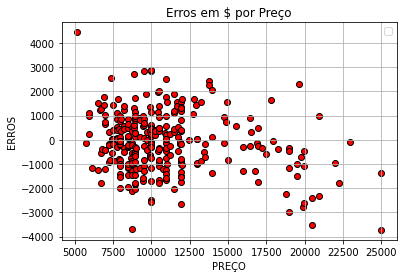

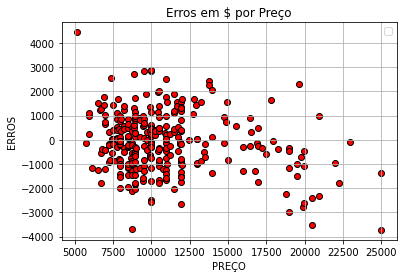

In [40]:
from sklearn import metrics

fig, ax = plt.subplots()

y_pred = predicoes.toPandas().prediction
y_test = predicoes.toPandas().PRECO

# Make a list of all the errors in the test-dataset:
errors = (y_pred - y_test)

### Populate the figure
# Plot the test-data:
plt.scatter(teste.toPandas().PRECO, errors, color='red', edgecolors='black')

# Set various labels
plt.ylabel('ERROS')
plt.xlabel('PREÇO')

plt.title('Erros em $ por Preço')

# Extras?
plt.grid() # Turn plot-grid on
plt.legend()

# Show figure
display(fig)